In [4]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
#from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#sim_name = 'TNG100-1'
sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
mass_multiplier = 1e10
log_mass_shift = 10

In [6]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'

with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

fn_dark_halo_arr = halo_params['halo']['fn_dark_halo_arr']

In [7]:
sim_reader = SimulationReader(halo_params['sim']['base_dir'], sim_name, sim_name_dark, 
                              halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [8]:
sim_reader.add_catalog_property_to_halos('m200m')
sim_reader.add_catalog_property_to_halos('r200m')
sim_reader.add_catalog_property_to_halos('v200m')

sim_reader.add_catalog_property_to_halos('x_minPE')
sim_reader.add_catalog_property_to_halos('x_grouppos')
sim_reader.add_catalog_property_to_halos('x_com')

In [9]:
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
r_200m = np.array([dark_halo.catalog_properties['r200m'] for dark_halo in sim_reader.dark_halo_arr])
v_200m = np.array([dark_halo.catalog_properties['v200m'] for dark_halo in sim_reader.dark_halo_arr])

In [10]:
mean_density_header = sim_reader.get_mean_density_from_header()
print(mean_density_header)

/scratch/ksf293/equivariant-cosmology/data/TNG50-4-Dark/output/snapdir_099/snap_099.0.hdf5
19683000 269.99999999999994 35000.0 4.590787172011662e-07
8.573518713601256e-09


In [11]:
mean_density_mr200m = sim_reader.get_mean_density_from_mr200m()
print(mean_density_mr200m)

8.571204464475928e-09


yay they match! 

## Check diff bw grouppos and minPE

In [9]:
xs_minPE = np.array([dark_halo.catalog_properties['x_minPE'] for dark_halo in sim_reader.dark_halo_arr])
xs_grouppos = np.array([dark_halo.catalog_properties['x_grouppos'] for dark_halo in sim_reader.dark_halo_arr])

In [10]:
np.allclose(xs_minPE, xs_grouppos)

True

Omg so i can just check that they're all close and then we should be able to use the m200ms in catalog!! phewwww  

## Test on single halo

In [11]:
halo = sim_reader.dark_halo_arr[100]

In [12]:
print(halo.catalog_properties['m200m'])
print(halo.catalog_properties['r200m'])

224.92757
315.23105


In [13]:
center_halo = 'x_grouppos'

In [14]:
halo.compute_MXV_rms(center_halo, sim_reader.m_dmpart_dark)
print(halo.M_rms)
print(halo.X_rms)

144.95913175999416
171.11836084832578


In [15]:
print(mean_density_header*200/sim_reader.m_dmpart_dark)

9.181574344023324e-05


In [16]:
print(mean_density_mr200m*200/sim_reader.m_dmpart_dark)

9.179095962497069e-05


In [17]:
halo.compute_mrv_200m(mean_density_header, sim_reader.m_dmpart_dark, sim_reader.mass_multiplier, center=center_halo)
print(halo.catalog_properties['m200m'])
print(halo.catalog_properties['r200m'])

206.81234541486413
307.08715859654455


## Compare for all halos

### RMS values

In [18]:
center_halo = 'x_grouppos'
for halo in sim_reader.dark_halo_arr:
    halo.compute_MXV_rms(center_halo, sim_reader.m_dmpart_dark)

In [19]:
m_rms = np.array([dark_halo.M_rms for dark_halo in sim_reader.dark_halo_arr])
r_rms = np.array([dark_halo.X_rms for dark_halo in sim_reader.dark_halo_arr])

Text(0, 0.5, '$log(M_\\mathrm{rms}$), computed')

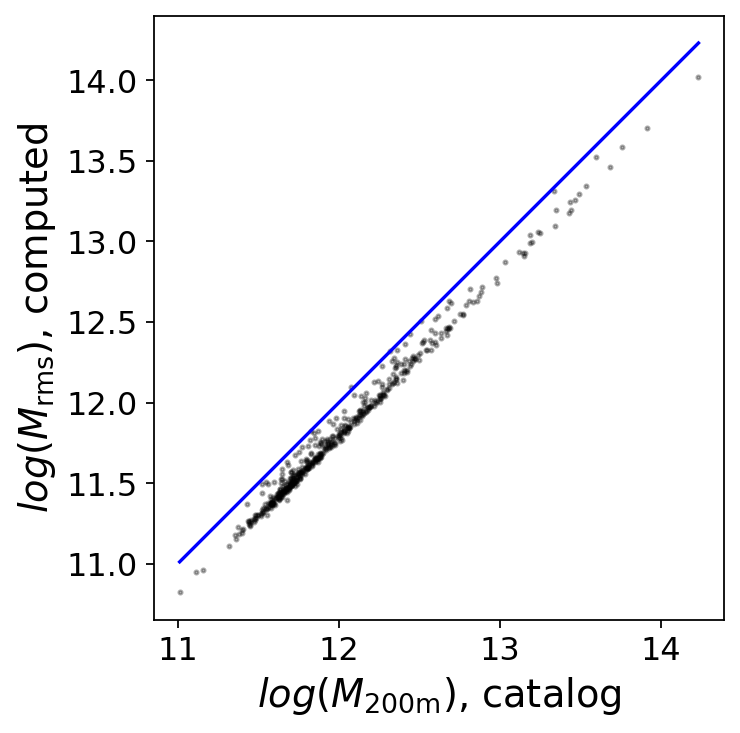

In [20]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10(m_200m)+log_mass_shift, np.log10(m_rms)+log_mass_shift, color='k', s=3, alpha=0.3) 
xx = np.linspace(np.min(np.log10(m_200m)), np.max(np.log10(m_200m)))+log_mass_shift
plt.plot(xx, xx, color='blue')
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel(r'$log(M_\mathrm{200m}$), catalog')
plt.ylabel(r'$log(M_\mathrm{rms}$), computed')

Text(0, 0.5, '$log(R_\\mathrm{rms}$), computed')

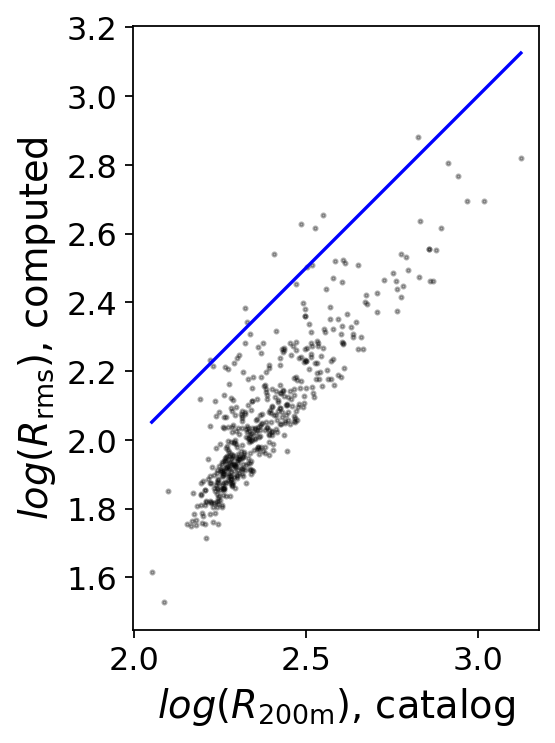

In [21]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10(r_200m), np.log10(r_rms), color='k', s=3, alpha=0.3) 
xx = np.linspace(np.min(np.log10(r_200m)), np.max(np.log10(r_200m)))
plt.plot(xx, xx, color='blue')
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel(r'$log(R_\mathrm{200m}$), catalog')
plt.ylabel(r'$log(R_\mathrm{rms}$), computed')

### 200\*mean density values (computed from header)

In [26]:
count = 0
center_halo = 'x_grouppos'
#rands = np.random.randint(0, len(sim_reader.dark_halo_arr), size=1000)
#for halo in sim_reader.dark_halo_arr[rands]:
for halo in sim_reader.dark_halo_arr:
    halo.compute_mrv_200m(mean_density_header, sim_reader.m_dmpart_dark, sim_reader.mass_multiplier, center=center_halo)
    if count%100==0:
        print(count)
    count += 1

0
100
200
300
400


In [27]:
m_200m_calc = np.array([halo.catalog_properties['m200m'] for halo in sim_reader.dark_halo_arr])
r_200m_calc = np.array([halo.catalog_properties['r200m'] for halo in sim_reader.dark_halo_arr])

Text(0, 0.5, '$log(M_\\mathrm{200m}$), computed')

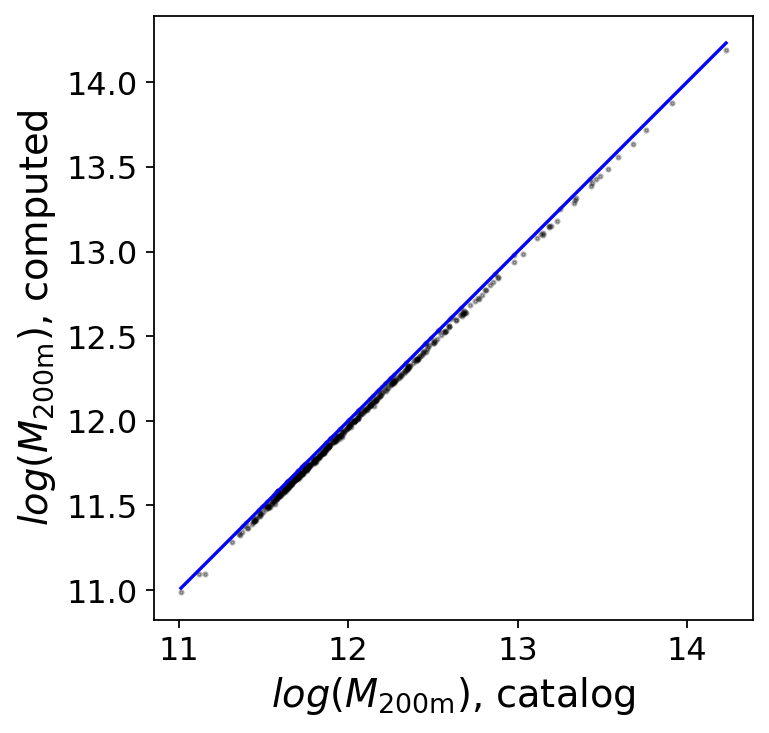

In [24]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10(m_200m)+log_mass_shift, np.log10(m_200m_calc)+log_mass_shift, color='k', s=3, alpha=0.3) 
xx = np.linspace(np.min(np.log10(m_200m)), np.max(np.log10(m_200m)))+log_mass_shift
plt.plot(xx, xx, color='blue')
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel(r'$log(M_\mathrm{200m}$), catalog')
plt.ylabel(r'$log(M_\mathrm{200m}$), computed')

Text(0, 0.5, '$log(R_\\mathrm{rms}$), computed')

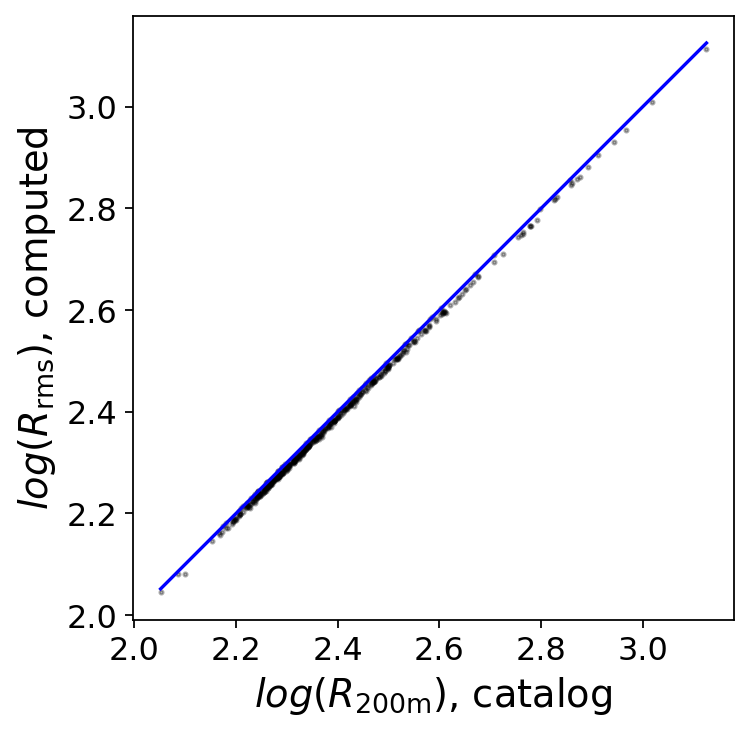

In [25]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10(r_200m), np.log10(r_200m_calc), color='k', s=3, alpha=0.3) 
xx = np.linspace(np.min(np.log10(r_200m)), np.max(np.log10(r_200m)))
plt.plot(xx, xx, color='blue')
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel(r'$log(R_\mathrm{200m}$), catalog')
plt.ylabel(r'$log(R_\mathrm{rms}$), computed')

I don't know why there's this small offset!! Think I fixed all m_dmpart issues??

### 200m with mean density computed from catalog 200m values

In [26]:
mean_density_mr200m, mean_density_header

(8.571204464475928e-09, 8.573518713601256e-09)

In [27]:
for halo in sim_reader.dark_halo_arr:
    halo.compute_mrv_200m(mean_density_mr200m, sim_reader.m_dmpart_dark, sim_reader.mass_multiplier, center=center_halo)

In [28]:
m_200m_calc = np.array([halo.catalog_properties['m200m'] for halo in sim_reader.dark_halo_arr])
r_200m_calc = np.array([halo.catalog_properties['r200m'] for halo in sim_reader.dark_halo_arr])

Text(0, 0.5, '$log(M_\\mathrm{200m}$), computed')

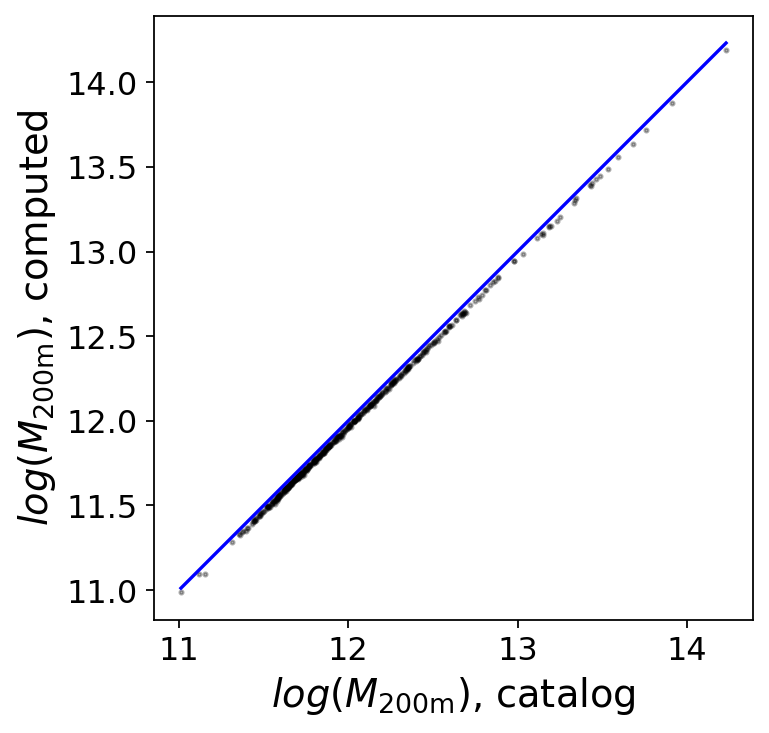

In [29]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10(m_200m)+log_mass_shift, np.log10(m_200m_calc)+log_mass_shift, color='k', s=3, alpha=0.3) 
xx = np.linspace(np.min(np.log10(m_200m)), np.max(np.log10(m_200m)))+log_mass_shift
plt.plot(xx, xx, color='blue')
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel(r'$log(M_\mathrm{200m}$), catalog')
plt.ylabel(r'$log(M_\mathrm{200m}$), computed')

Text(0, 0.5, '$log(R_\\mathrm{200m}$), computed')

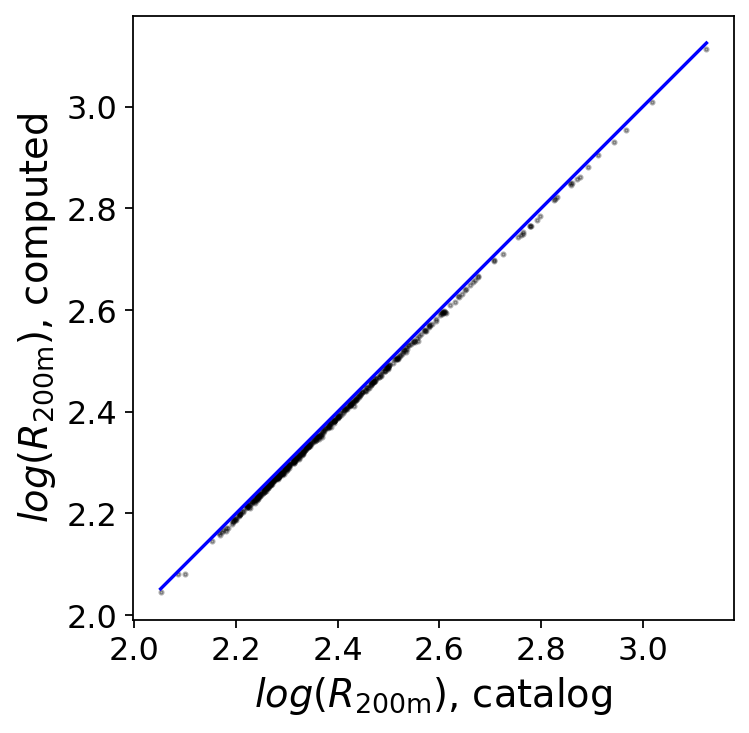

In [30]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10(r_200m), np.log10(r_200m_calc), color='k', s=3, alpha=0.3) 
xx = np.linspace(np.min(np.log10(r_200m)), np.max(np.log10(r_200m)))
plt.plot(xx, xx, color='blue')
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel(r'$log(R_\mathrm{200m}$), catalog')
plt.ylabel(r'$log(R_\mathrm{200m}$), computed')

## Center on x_minPE

In [31]:
center_halo = 'x_minPE'
for halo in sim_reader.dark_halo_arr:
    halo.compute_mrv_200m(mean_density_header, sim_reader.m_dmpart_dark, sim_reader.mass_multiplier, center=center_halo)

In [32]:
m_200m_calc = np.array([halo.catalog_properties['m200m'] for halo in sim_reader.dark_halo_arr])
r_200m_calc = np.array([halo.catalog_properties['r200m'] for halo in sim_reader.dark_halo_arr])

Text(0, 0.5, '$log(M_\\mathrm{200m}$), computed')

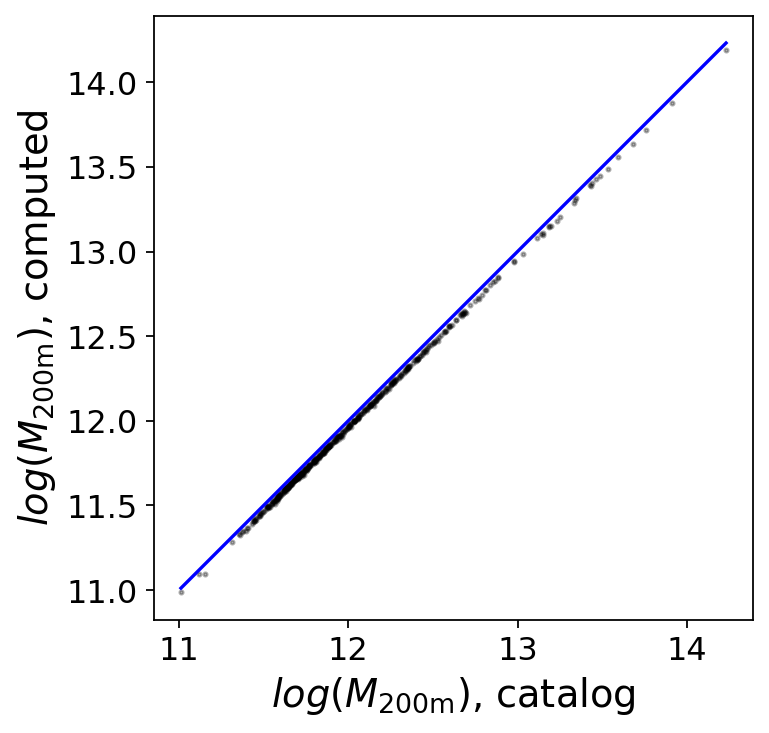

In [33]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10(m_200m)+log_mass_shift, np.log10(m_200m_calc)+log_mass_shift, color='k', s=3, alpha=0.3) 
xx = np.linspace(np.min(np.log10(m_200m)), np.max(np.log10(m_200m)))+log_mass_shift
plt.plot(xx, xx, color='blue')
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel(r'$log(M_\mathrm{200m}$), catalog')
plt.ylabel(r'$log(M_\mathrm{200m}$), computed')

Text(0, 0.5, '$log(R_\\mathrm{200m}$), computed')

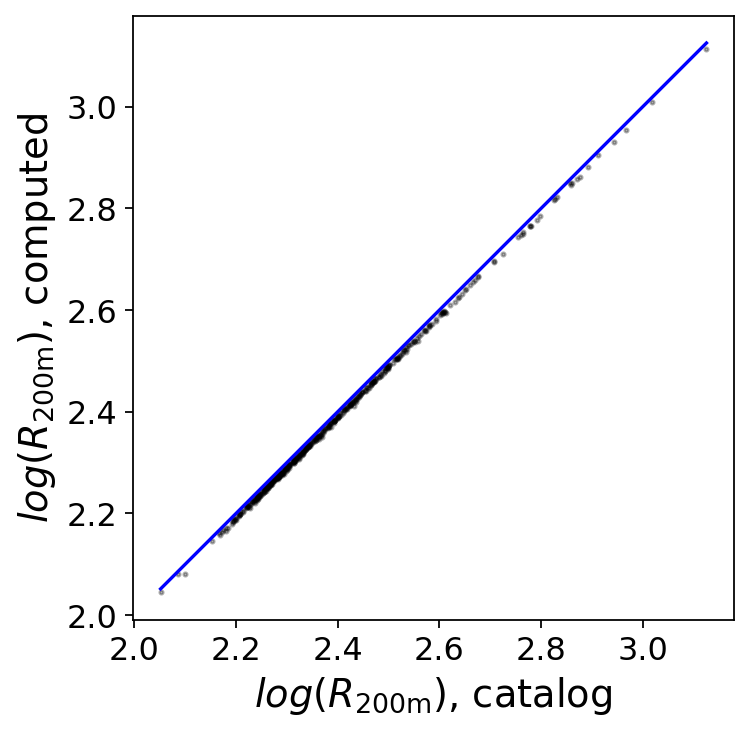

In [34]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10(r_200m), np.log10(r_200m_calc), color='k', s=3, alpha=0.3) 
xx = np.linspace(np.min(np.log10(r_200m)), np.max(np.log10(r_200m)))
plt.plot(xx, xx, color='blue')
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel(r'$log(R_\mathrm{200m}$), catalog')
plt.ylabel(r'$log(R_\mathrm{200m}$), computed')

Ok so x_minPE is almost always the same as x_grouppos, bc they are the most bound particle position for the most massive subhalo and the FOF halo respectively, and often the most massive subhalo will contain the FOF's most bound particle. But this is not guaranteed, so we need to recompute!

# Compare geometric features computed with R200m catalog

In [12]:
# geo info
geo_dir = f'../data/geometric_features/geometric_features_{sim_name}'
geo_tag = ''
halo_tag = '' # TODO: diff halo tag now, since config setup!
fn_geo_features = f'{geo_dir}/geometric_features_{sim_name}{halo_tag}{geo_tag}.npy'
print(fn_geo_features)

../data/geometric_features/geometric_features_TNG50-4/geometric_features_TNG50-4.npy


In [13]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(fn_geo_features)

In [14]:
n_groups = [[0,1,2,3,4,5,6,7]]
geo_feature_arr_rebinned = utils.rebin_geometric_features(geo_featurizer.geo_feature_arr, n_groups)
geo_feature_arr_pseudo = utils.transform_pseudotensors(geo_feature_arr_rebinned)

In [20]:
m200m_geo = []
for geos_halo in geo_feature_arr_pseudo:
    for geo in geos_halo:
        #print(geo_name(geo))
        if geo.x_order==0 and geo.v_order==0:
            m200m_geo.append(geo.value)

In [21]:
print(len(m200m_geo))
print(len(geo_feature_arr_pseudo))

487
487


Text(0, 0.5, '$log(M_\\mathrm{200m}$), from geometric feature')

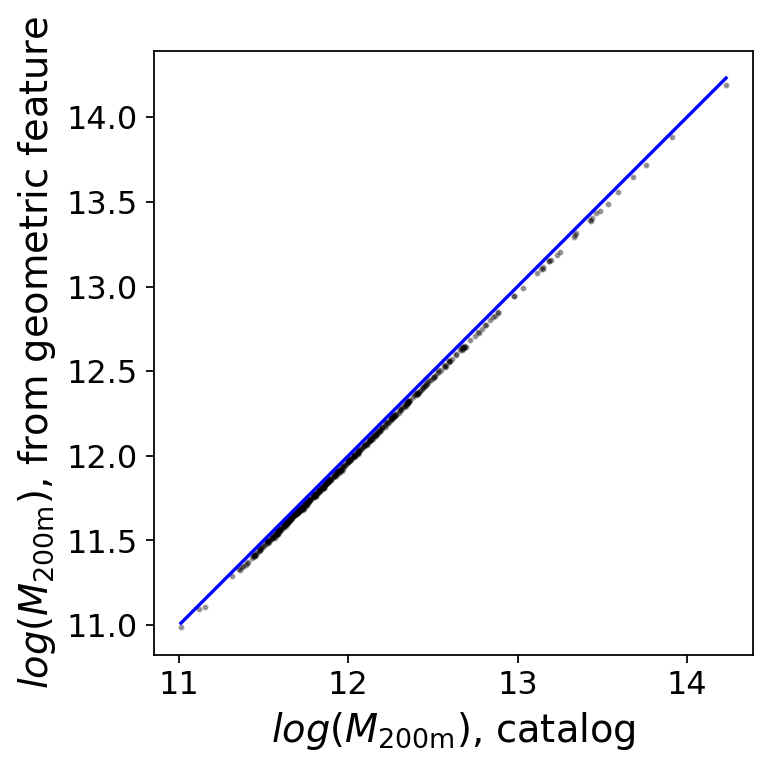

In [22]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10(m_200m)+log_mass_shift, np.log10(m200m_geo)+log_mass_shift, color='k', s=3, alpha=0.3) 
xx = np.linspace(np.min(np.log10(m_200m)), np.max(np.log10(m_200m)))+log_mass_shift
plt.plot(xx, xx, color='blue')
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel(r'$log(M_\mathrm{200m}$), catalog')
plt.ylabel(r'$log(M_\mathrm{200m}$), from geometric feature')

Hmmm. if the difference were due to the catalog including only FOF group particles and not some background ones, then the geo feature one should be higher, not lower! idk..

Text(0, 0.5, '$log(M_\\mathrm{200m}$), from geometric feature')

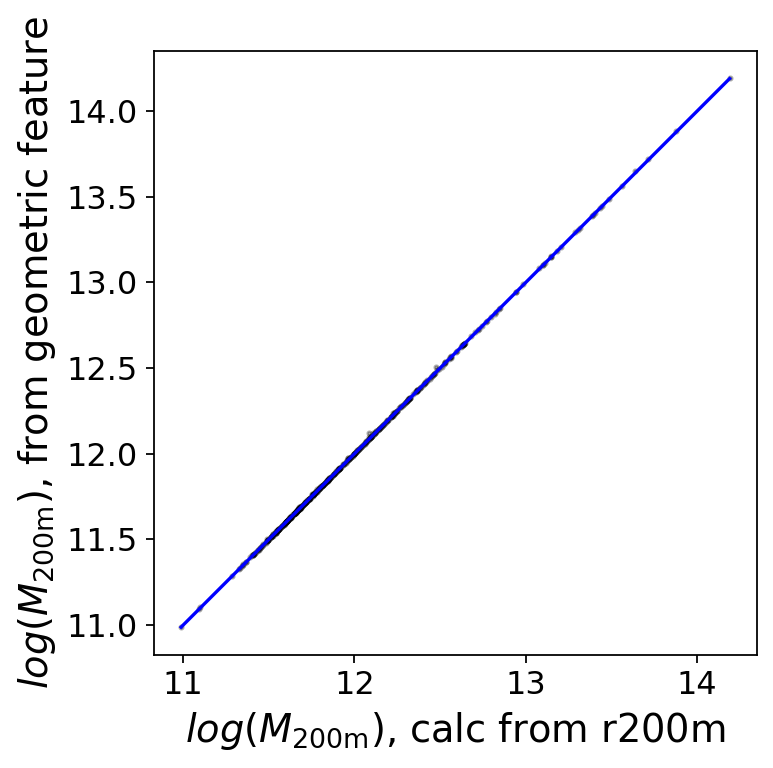

In [28]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10(m_200m_calc)+log_mass_shift, np.log10(m200m_geo)+log_mass_shift, color='k', s=3, alpha=0.3) 
xx = np.linspace(np.min(np.log10(m_200m_calc)), np.max(np.log10(m_200m_calc)))+log_mass_shift
plt.plot(xx, xx, color='blue')
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel(r'$log(M_\mathrm{200m}$), calc from r200m')
plt.ylabel(r'$log(M_\mathrm{200m}$), from geometric feature')

Ok those line up, good - though not sure why not _exactly_